# Change Detection

In [1]:
import geoai
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from pathlib import Path
from geoai.change_detection import ChangeDetection
import geopandas as gpd
from IPython.display import Image

from libs.sentinel import get_sentinel_image_thumbnail
from libs.ee import initialize_ee
ee = initialize_ee(get_ipython())

from libs.s2cloudless import S2Cloudless

In [2]:
directory = 'data/NZ_landslide_inventory/'
auckland_filepath = f'{directory}/cleaned_auckland.gpkg'
gdf = gpd.read_file(auckland_filepath, layer='landslides')
gdf = gdf[gdf['dateoccurence'].notnull()]
gdf

,GlobalID,latitude,longitude,region,dateoccurence,closestdate,geometry
0,cb20f8d7-abeb-4ce5-bafa-a75c01b03136,-36.931306,174.701880,Auckland Region,2023-02-13 23:00:00,2023-02-13 23:00:00,POINT (174.70188 -36.93131)
1,9da581bc-ff20-454f-b6fb-721279cd347a,-36.924269,174.705747,Auckland Region,2023-01-30 23:00:00,2023-01-30 23:00:00,POINT (174.70575 -36.92427)
2,2a361da4-7adf-4f4d-b94c-f3cf9ccccc46,-36.867368,174.738318,Auckland Region,2023-01-31 23:00:00,2023-01-31 23:00:00,POINT (174.73832 -36.86737)
3,4470b30b-6c80-46be-b0f7-e4ec0a5d72fd,-36.861593,174.655298,Auckland Region,2023-02-13 23:00:00,2023-02-13 23:00:00,POINT (174.6553 -36.86159)
4,cfcff56a-7cc6-41f5-9e7e-8da0daa5dbde,-36.817738,174.728127,Auckland Region,2023-01-31 23:00:00,2023-01-31 23:00:00,POINT (174.72813 -36.81774)
...,...,...,...,...,...,...,...
11911,8ac9ffa6-d365-4cb0-bc15-e54c10a63d8b,-36.807419,174.690856,Auckland Region,2023-01-26 11:00:00,2023-01-26 11:00:00,POINT (174.69086 -36.80742)
11912,2801a385-dc6a-44b3-9355-64140b2f1929,-37.133864,174.706530,Auckland Region,2023-01-26 11:00:00,2023-01-26 11:00:00,POINT (174.70653 -37.13386)
11913,c8cc9f20-efac-41b4-bf62-55a625a2ab6e,-36.938192,174.629223,Auckland Region,2023-01-26 11:00:00,2023-01-26 11:00:00,POINT (174.62922 -36.93819)
11914,fa946895-4967-4a14-9b59-48dd0898766e,-36.944683,174.663084,Auckland Region,2023-01-27 11:00:00,2023-01-27 08:00:00,POINT (174.66308 -36.94468)


GlobalID               4760d800-3db6-494b-923f-84f1353cc6c3
latitude                                          -36.95099
longitude                                        174.582021
region                                      Auckland Region
dateoccurence                           2023-01-29 00:00:00
closestdate                             2023-01-29 00:00:00
geometry         POINT (174.582021363252 -36.9509901510936)
Name: 7986, dtype: object

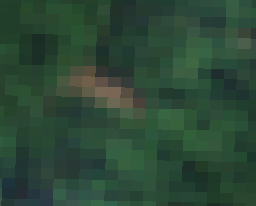

In [3]:
auckland_dir = './data/2-data-explore-events'

event = gdf.loc[7986]

landslide_img = f'{auckland_dir}/images/7968_174.575889109309_-36.9510233656217_2023-01-29_2023-02-19.png'

display(event)
display(Image(filename=landslide_img))

## Find before landslide images

In [4]:
start_date = (
        event['dateoccurence'].date() - pd.Timedelta(days=60)
    ).strftime("%Y-%m-%d")
end_date = event['dateoccurence'].date().strftime("%Y-%m-%d")

start_date, end_date

('2022-11-30', '2023-01-29')

In [5]:
s2cloudless = S2Cloudless(ee)

point = event['geometry']
# Extract coordinates from Shapely Point
lon = point.x
lat = point.y

# Create Earth Engine Point geometry
aoi = ee.Geometry.Point([lon, lat]).buffer(1000)

# start_date
# end_date,
buffer=50
cloud_filter=30

m_cloud_free = s2cloudless.cloud_free_map(aoi, start_date, end_date, buffer=buffer, cloud_filter=cloud_filter)
m_cloud_free.addLayer(ee.Geometry.Point([lon, lat]), {'color': 'red'}, 'My Pinpoint')
m_cloud_free

Map(center=[-36.95098912519603, 174.582021398851], controls=(WidgetControl(options=['position', 'transparent_b…

## Export all `tif` file

'Filename ./data/4_change_detection/images/0_174.701880487593_-36.931306466746_2022-12-15_2023-02-07.tif'

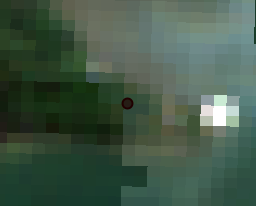

'Filename ./data/4_change_detection/images/1_174.70574721288_-36.9242685339089_2022-12-01_2023-01-24.tif'

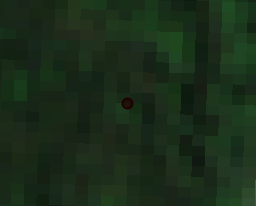

'Filename ./data/4_change_detection/images/2_174.738317563251_-36.8673683761872_2022-12-02_2023-01-25.tif'

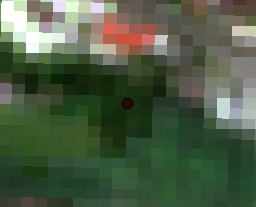

'Filename ./data/4_change_detection/images/3_174.655298082793_-36.8615929062174_2022-12-15_2023-02-07.tif'

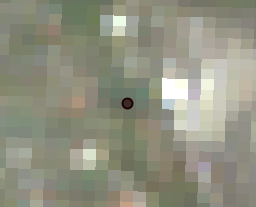

'Filename ./data/4_change_detection/images/4_174.728126662222_-36.8177384118568_2022-12-02_2023-01-25.tif'

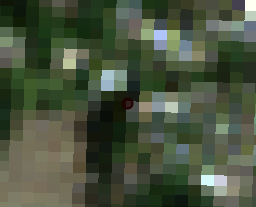

'Filename ./data/4_change_detection/images/5_174.767440064505_-36.9257813698387_2022-12-02_2023-01-25.tif'

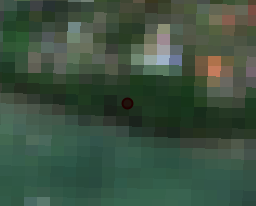

'Filename ./data/4_change_detection/images/6_174.702992745634_-36.927593097499_2022-12-15_2023-02-07.tif'

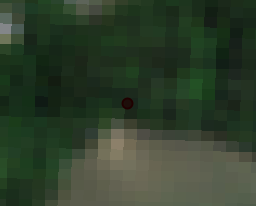

'Filename ./data/4_change_detection/images/7_174.653319614685_-37.0943919015828_2022-12-02_2023-01-25.tif'

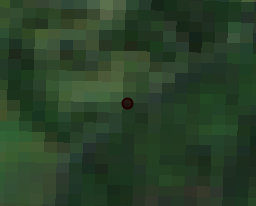

'Filename ./data/4_change_detection/images/8_174.746297568181_-36.8198594698531_2022-11-27_2023-01-20.tif'

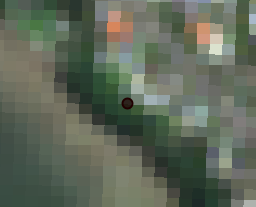

'Filename ./data/4_change_detection/images/9_174.716829737716_-36.9256941844427_2022-11-28_2023-01-21.tif'

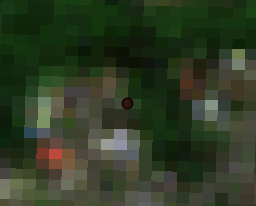

'Filename ./data/4_change_detection/images/10_174.684934100793_-36.7981335088127_2022-11-27_2023-01-20.tif'

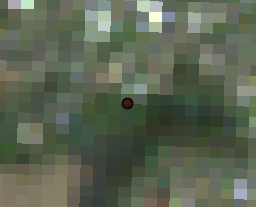

'Filename ./data/4_change_detection/images/11_174.780755882151_-36.8671726423134_2022-11-28_2023-01-21.tif'

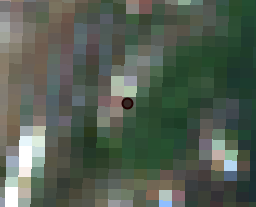

'Filename ./data/4_change_detection/images/12_174.805942955392_-36.8146697292219_2022-12-09_2023-02-01.tif'

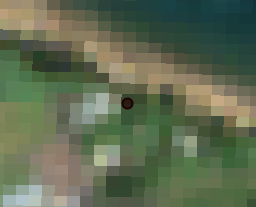

'Filename ./data/4_change_detection/images/13_174.668769561378_-36.9409476953432_2022-11-27_2023-01-20.tif'

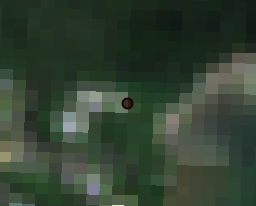

'Filename ./data/4_change_detection/images/14_174.744603895868_-36.9327879614425_2022-11-27_2023-01-20.tif'

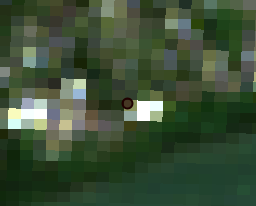

'Filename ./data/4_change_detection/images/15_174.792091678656_-36.8528847235917_2022-11-27_2023-01-20.tif'

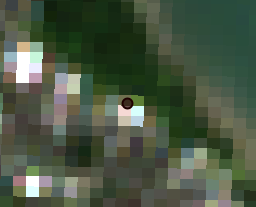

'Filename ./data/4_change_detection/images/16_174.603559053774_-37.0492662414968_2022-11-30_2023-01-23.tif'

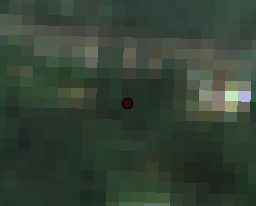

'Filename ./data/4_change_detection/images/17_174.718140918215_-36.809204304505_2022-11-28_2023-01-21.tif'

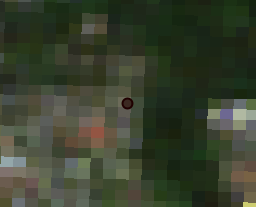

'Filename ./data/4_change_detection/images/18_174.774452329219_-36.8287983377214_2022-05-12_2022-07-05.tif'

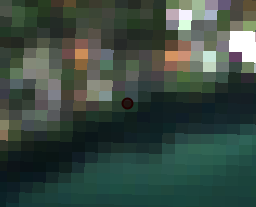

'Filename ./data/4_change_detection/images/19_174.653319614685_-37.0943919015828_2022-12-02_2023-01-25.tif'

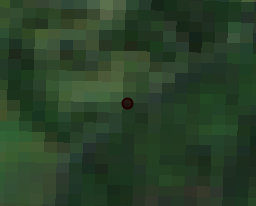

'Filename ./data/4_change_detection/images/20_174.679846096852_-36.7902605295893_2022-12-15_2023-02-07.tif'

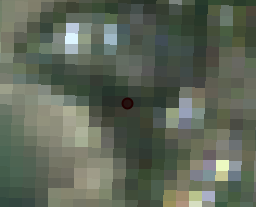

'Filename ./data/4_change_detection/images/21_174.690636905342_-36.8075358289513_2022-11-27_2023-01-20.tif'

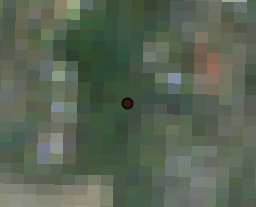

'Filename ./data/4_change_detection/images/22_174.690836038566_-36.8065082853975_2022-11-27_2023-01-20.tif'

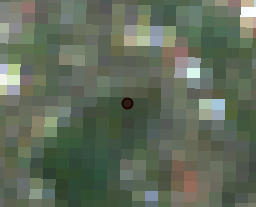

'Filename ./data/4_change_detection/images/23_174.701830351479_-36.9291273725072_2022-11-28_2023-01-21.tif'

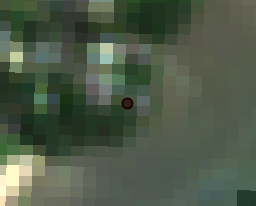

'Filename ./data/4_change_detection/images/24_174.740327212528_-36.9303378195003_2022-11-27_2023-01-20.tif'

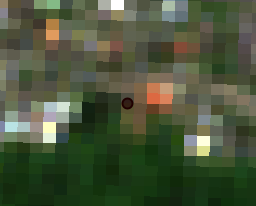

'Filename ./data/4_change_detection/images/25_174.733943611578_-36.7290558942885_2022-11-27_2023-01-20.tif'

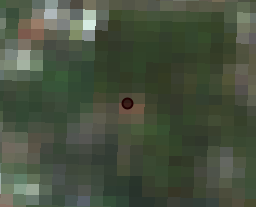

'Filename ./data/4_change_detection/images/26_174.744548160301_-36.932751103574_2022-11-27_2023-01-20.tif'

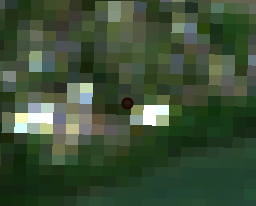

'Filename ./data/4_change_detection/images/27_174.735599688997_-36.9306710887067_2022-11-27_2023-01-20.tif'

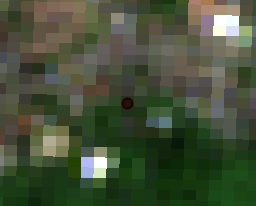

'Filename ./data/4_change_detection/images/28_174.482342131895_-36.9904166513491_2022-12-14_2023-02-06.tif'

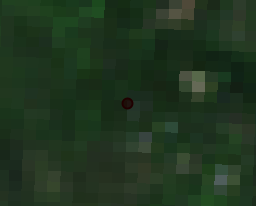

'Filename ./data/4_change_detection/images/29_174.668662142897_-36.9409641195673_2022-11-27_2023-01-20.tif'

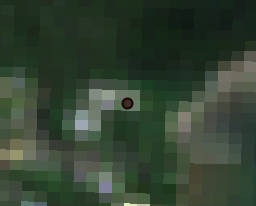

'Filename ./data/4_change_detection/images/30_174.592089374329_-36.9343760881123_2022-11-30_2023-01-23.tif'

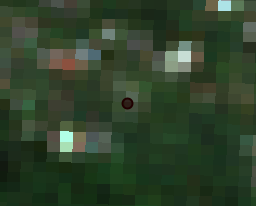

'Filename ./data/4_change_detection/images/31_174.718009293736_-36.8097607707592_2022-11-27_2023-01-20.tif'

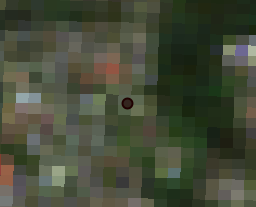

'Filename ./data/4_change_detection/images/32_174.607493506968_-36.9119146299933_2022-11-27_2023-01-20.tif'

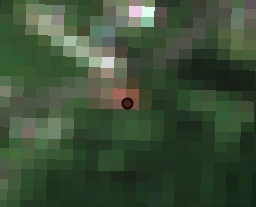

'Filename ./data/4_change_detection/images/33_174.713281988151_-36.8142905588939_2022-11-27_2023-01-20.tif'

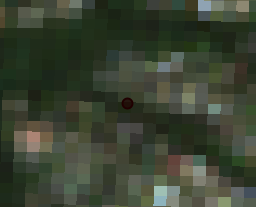

'Filename ./data/4_change_detection/images/126_174.666256109306_-36.7767912239579_2022-11-27_2023-01-20.tif'

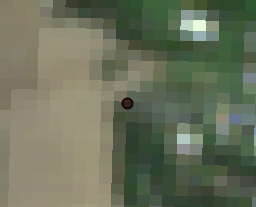

'Filename ./data/4_change_detection/images/155_174.744335157125_-36.9316484817737_2022-11-27_2023-01-20.tif'

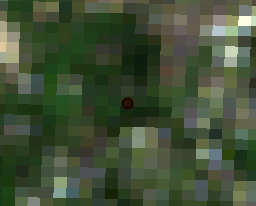

'Filename ./data/4_change_detection/images/1476_174.708104355375_-36.7902161604464_2022-11-28_2023-01-21.tif'

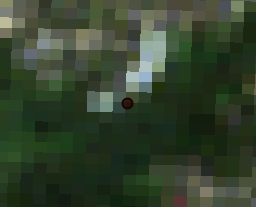

'Filename ./data/4_change_detection/images/1477_174.773966037271_-36.8289442494683_2022-11-27_2023-01-20.tif'

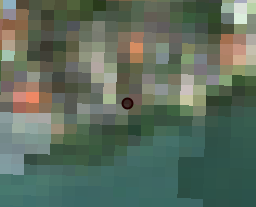

'Filename ./data/4_change_detection/images/1478_174.690928658615_-36.807560936298_2022-11-27_2023-01-20.tif'

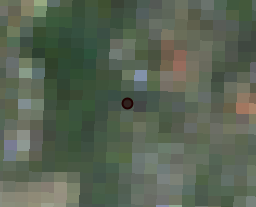

'Filename ./data/4_change_detection/images/1479_174.713944365606_-36.8140062237813_2022-11-27_2023-01-20.tif'

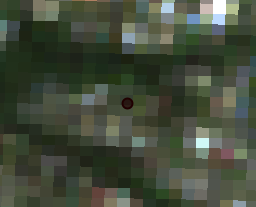

'Filename ./data/4_change_detection/images/1480_174.633112359622_-36.8229753352294_2022-11-27_2023-01-20.tif'

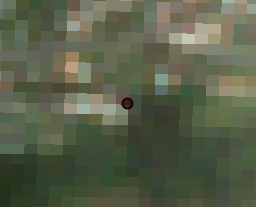

'Filename ./data/4_change_detection/images/1481_174.707183381082_-36.8130271996791_2022-11-27_2023-01-20.tif'

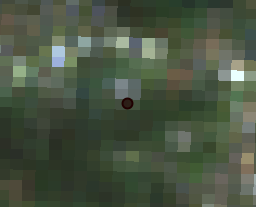

'Filename ./data/4_change_detection/images/1482_174.721033503283_-36.9080981955805_2022-11-27_2023-01-20.tif'

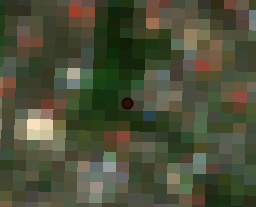

'Filename ./data/4_change_detection/images/1483_174.734117170421_-36.8159845289851_2022-11-27_2023-01-20.tif'

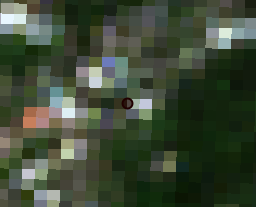

'Filename ./data/4_change_detection/images/1484_174.734117170421_-36.8159845289851_2022-11-27_2023-01-20.tif'

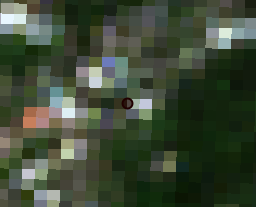

'Filename ./data/4_change_detection/images/2814_174.544090659079_-36.9627503873394_2022-11-30_2023-01-23.tif'

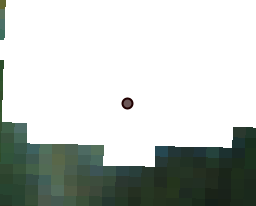

'Filename ./data/4_change_detection/images/2815_174.546790668392_-36.9653158287915_2022-11-30_2023-01-23.tif'

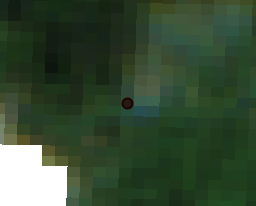

'Filename ./data/4_change_detection/images/2848_174.570893022429_-36.9591852201549_2021-12-03_2022-01-26.tif'

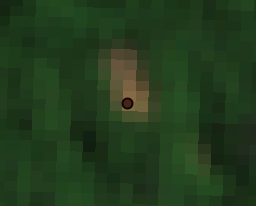

'Filename ./data/4_change_detection/images/6938_174.550486030106_-37.0063003801909_2021-12-03_2022-01-26.tif'

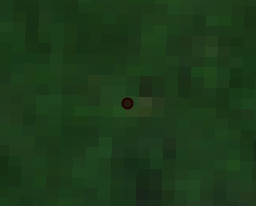

'Filename ./data/4_change_detection/images/6939_174.53325358775_-36.9972893271872_2021-12-03_2022-01-26.tif'

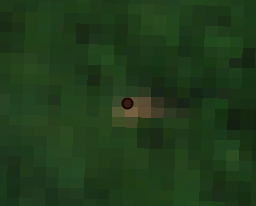

'Filename ./data/4_change_detection/images/6941_174.530978583615_-36.9997044460754_2021-12-03_2022-01-26.tif'

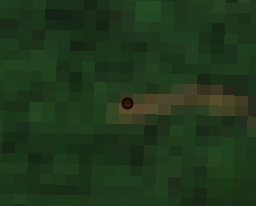

'Filename ./data/4_change_detection/images/7965_174.573516101499_-36.9464628363797_2022-11-30_2023-01-23.tif'

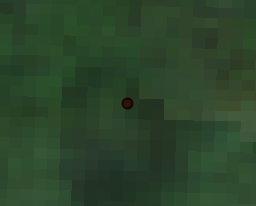

'Filename ./data/4_change_detection/images/7966_174.573490880108_-36.9481549532955_2022-11-30_2023-01-23.tif'

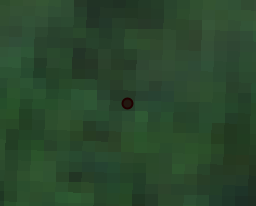

'Filename ./data/4_change_detection/images/7968_174.575889109309_-36.9510233656217_2022-11-30_2023-01-23.tif'

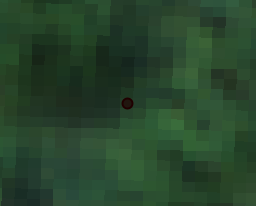

'Filename ./data/4_change_detection/images/7969_174.577281013646_-36.9505700309439_2022-11-30_2023-01-23.tif'

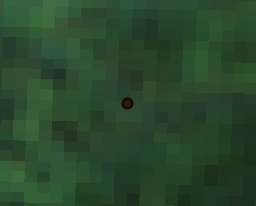

'Filename ./data/4_change_detection/images/7971_174.572866354871_-36.9540291236345_2021-12-03_2022-01-26.tif'

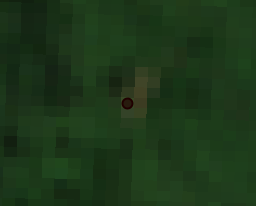

'Filename ./data/4_change_detection/images/7972_174.577888728775_-36.9520992164187_2022-11-30_2023-01-23.tif'

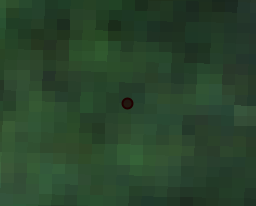

'Filename ./data/4_change_detection/images/7973_174.578704614064_-36.9516351476172_2022-11-30_2023-01-23.tif'

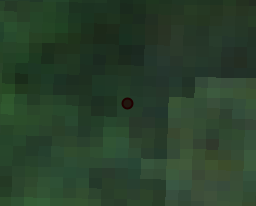

'Filename ./data/4_change_detection/images/7974_174.572762307717_-36.9592350261781_2022-11-30_2023-01-23.tif'

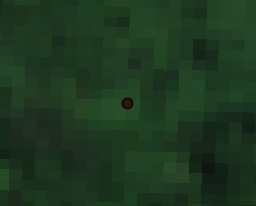

'Filename ./data/4_change_detection/images/7975_174.575279574077_-36.9584351646335_2022-11-30_2023-01-23.tif'

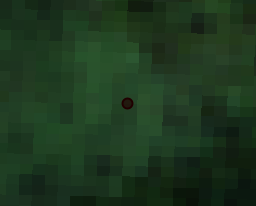

'Filename ./data/4_change_detection/images/7976_174.577717259425_-36.9580664211587_2022-11-30_2023-01-23.tif'

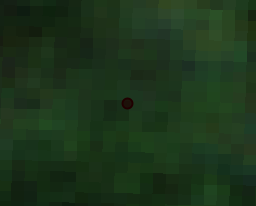

'Filename ./data/4_change_detection/images/7977_174.579242341409_-36.9587953893088_2022-11-30_2023-01-23.tif'

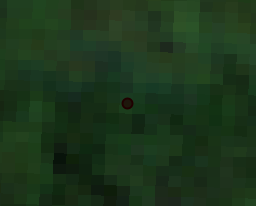

'Filename ./data/4_change_detection/images/7978_174.579243600964_-36.9593699484296_2022-11-30_2023-01-23.tif'

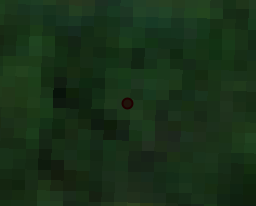

'Filename ./data/4_change_detection/images/7979_174.575606867627_-36.9660826406233_2022-11-30_2023-01-23.tif'

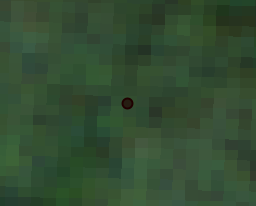

'Filename ./data/4_change_detection/images/7980_174.585081692206_-36.9664300458833_2022-11-30_2023-01-23.tif'

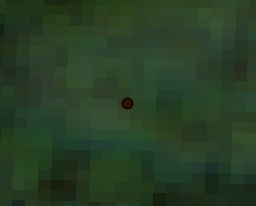

'Filename ./data/4_change_detection/images/7981_174.584706015723_-36.9624360618231_2022-11-30_2023-01-23.tif'

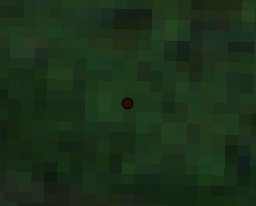

'Filename ./data/4_change_detection/images/7982_174.58384155424_-36.9619494767911_2022-11-30_2023-01-23.tif'

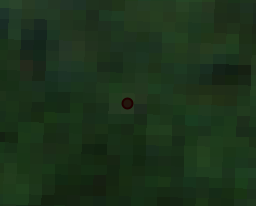

'Filename ./data/4_change_detection/images/7983_174.582493792056_-36.9612870536687_2022-11-30_2023-01-23.tif'

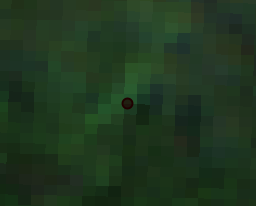

'Filename ./data/4_change_detection/images/7986_174.582021363252_-36.9509901510936_2022-11-30_2023-01-23.tif'

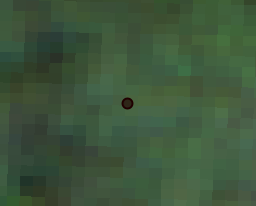

'Filename ./data/4_change_detection/images/7987_174.580579628912_-36.9497946392882_2022-11-30_2023-01-23.tif'

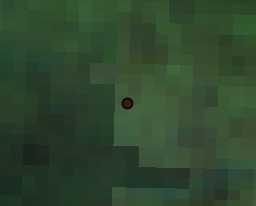

'Filename ./data/4_change_detection/images/7991_174.591389484467_-36.9490570230778_2022-11-30_2023-01-23.tif'

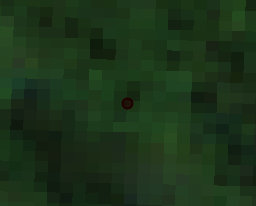

'Filename ./data/4_change_detection/images/7994_174.593843645655_-36.9648072361271_2022-11-30_2023-01-23.tif'

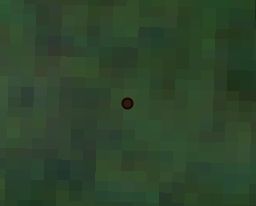

'Filename ./data/4_change_detection/images/7995_174.595133777708_-36.9654456074817_2022-11-30_2023-01-23.tif'

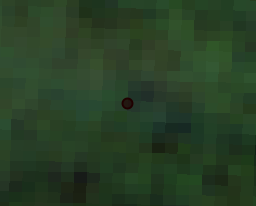

'Filename ./data/4_change_detection/images/7996_174.59173891446_-36.9652471775134_2022-11-30_2023-01-23.tif'

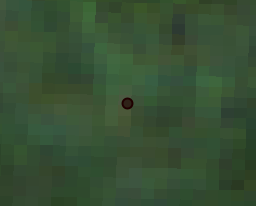

'Filename ./data/4_change_detection/images/8001_174.614567656146_-36.9459492455626_2022-11-30_2023-01-23.tif'

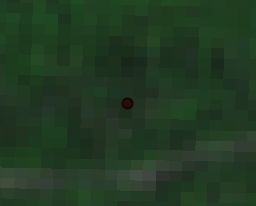

'Filename ./data/4_change_detection/images/8002_174.618987012271_-36.9505532614508_2022-11-30_2023-01-23.tif'

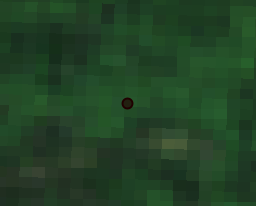

'Filename ./data/4_change_detection/images/8379_174.561811473118_-36.3577142709008_2022-11-30_2023-01-23.tif'

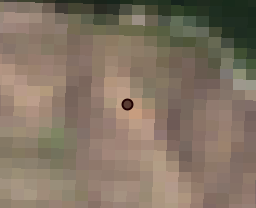

'Filename ./data/4_change_detection/images/8380_174.562673110788_-36.3580741444418_2022-11-30_2023-01-23.tif'

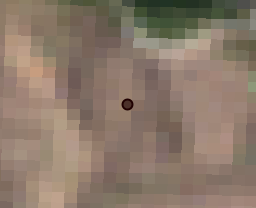

'Filename ./data/4_change_detection/images/8381_174.561108825628_-36.3578044703972_2022-11-30_2023-01-23.tif'

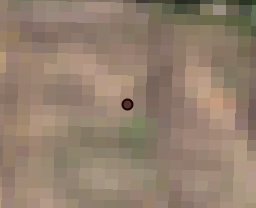

'Filename ./data/4_change_detection/images/8383_174.560386637975_-36.3571037134004_2022-11-30_2023-01-23.tif'

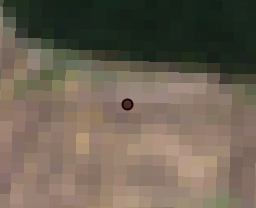

'Filename ./data/4_change_detection/images/8384_174.560437356884_-36.359016646068_2022-11-30_2023-01-23.tif'

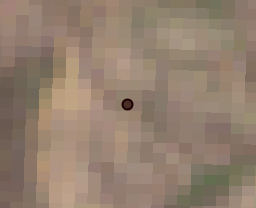

'Filename ./data/4_change_detection/images/8389_174.562962416805_-36.3589409683081_2022-11-30_2023-01-23.tif'

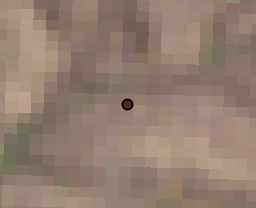

'Filename ./data/4_change_detection/images/8391_174.563372238163_-36.3598275728213_2022-11-30_2023-01-23.tif'

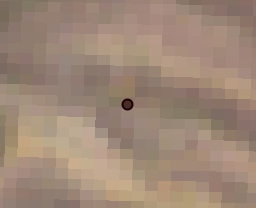

'Filename ./data/4_change_detection/images/8849_174.5695210266_-36.5294475746549_2022-11-30_2023-01-23.tif'

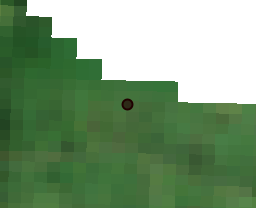

'Filename ./data/4_change_detection/images/8850_174.569118909234_-36.5274550352156_2022-11-30_2023-01-23.tif'

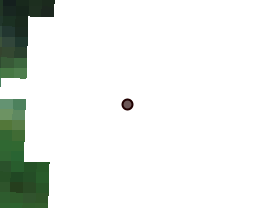

'Filename ./data/4_change_detection/images/8852_174.570230504355_-36.5270473260633_2022-11-30_2023-01-23.tif'

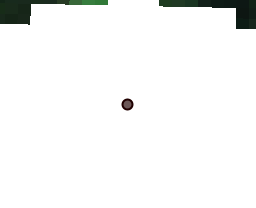

'Filename ./data/4_change_detection/images/8853_174.569671087489_-36.5269011306833_2022-11-30_2023-01-23.tif'

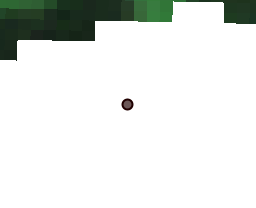

'Filename ./data/4_change_detection/images/8866_174.567747838123_-36.5191367689426_2022-11-30_2023-01-23.tif'

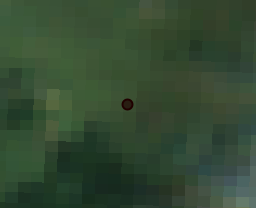

'Filename ./data/4_change_detection/images/8873_174.566209496476_-36.5292538014443_2022-11-30_2023-01-23.tif'

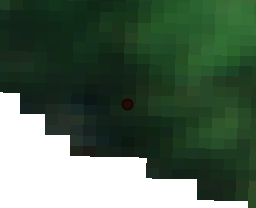

'Filename ./data/4_change_detection/images/8874_174.56648606749_-36.5291851294921_2022-11-30_2023-01-23.tif'

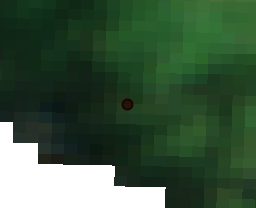

'Filename ./data/4_change_detection/images/8879_174.564914567677_-36.5303325073722_2022-11-30_2023-01-23.tif'

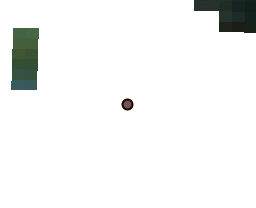

'Filename ./data/4_change_detection/images/8880_174.566130168601_-36.5289187875786_2022-11-30_2023-01-23.tif'

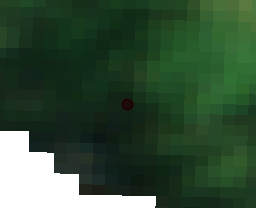

'Filename ./data/4_change_detection/images/8881_174.564871853299_-36.5242156659244_2022-11-30_2023-01-23.tif'

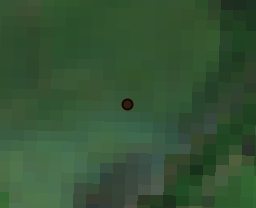

'Filename ./data/4_change_detection/images/8885_174.563906832433_-36.5248690075711_2022-11-30_2023-01-23.tif'

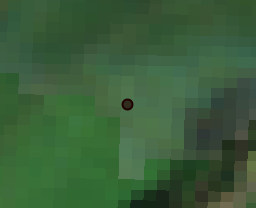

'Filename ./data/4_change_detection/images/8893_174.565060218458_-36.5195471775881_2022-11-30_2023-01-23.tif'

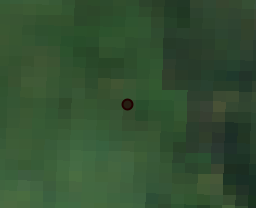

'Filename ./data/4_change_detection/images/8894_174.563853325987_-36.5191067221967_2022-11-30_2023-01-23.tif'

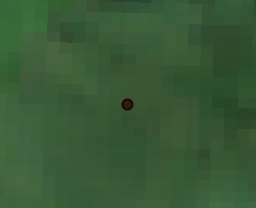

'Filename ./data/4_change_detection/images/8898_174.564275085535_-36.5184874986502_2022-11-30_2023-01-23.tif'

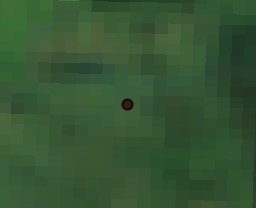

'Filename ./data/4_change_detection/images/9300_174.468092906694_-36.411291672432_2022-11-30_2023-01-23.tif'

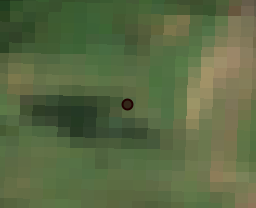

'Filename ./data/4_change_detection/images/9301_174.468114621085_-36.4116216909389_2022-11-30_2023-01-23.tif'

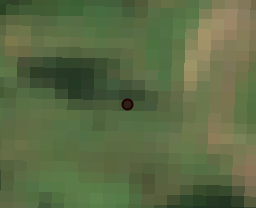

'Filename ./data/4_change_detection/images/9303_174.468396662561_-36.4097936003318_2022-11-30_2023-01-23.tif'

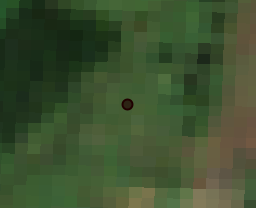

'Filename ./data/4_change_detection/images/9304_174.466973461464_-36.4109662474762_2022-11-30_2023-01-23.tif'

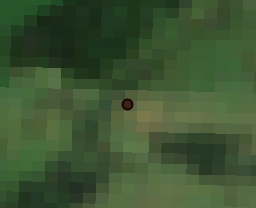

'Filename ./data/4_change_detection/images/9307_174.465700555523_-36.4096011298697_2022-11-30_2023-01-23.tif'

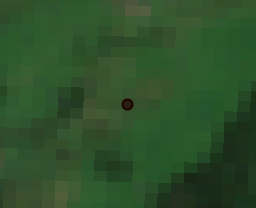

'Filename ./data/4_change_detection/images/9308_174.468757717415_-36.4072391596055_2022-11-30_2023-01-23.tif'

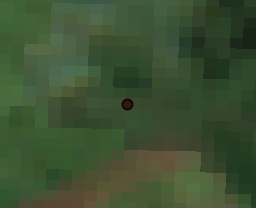

'Filename ./data/4_change_detection/images/9309_174.469006387344_-36.407328008982_2022-11-30_2023-01-23.tif'

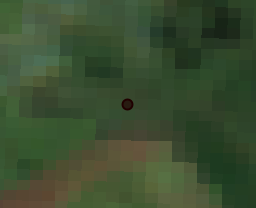

'Filename ./data/4_change_detection/images/9310_174.469915972146_-36.4075704837573_2022-11-30_2023-01-23.tif'

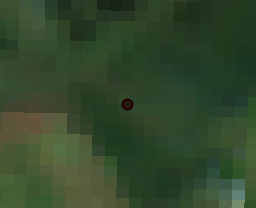

'Filename ./data/4_change_detection/images/9312_174.468837658181_-36.4082627634806_2022-11-30_2023-01-23.tif'

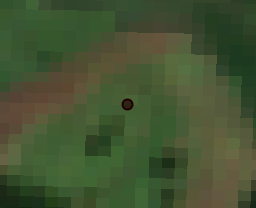

'Filename ./data/4_change_detection/images/9313_174.469052293236_-36.4080909217121_2022-11-30_2023-01-23.tif'

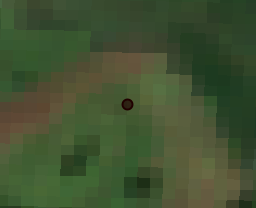

'Filename ./data/4_change_detection/images/9317_174.469074502962_-36.4098829415423_2022-11-30_2023-01-23.tif'

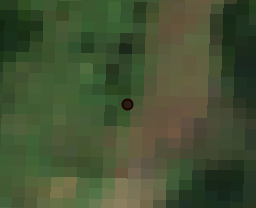

'Filename ./data/4_change_detection/images/9318_174.469061303888_-36.4096156661763_2022-11-30_2023-01-23.tif'

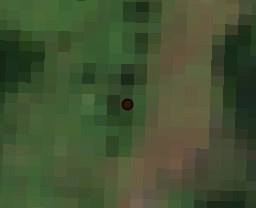

'Filename ./data/4_change_detection/images/9320_174.468581785848_-36.4105626297694_2022-11-30_2023-01-23.tif'

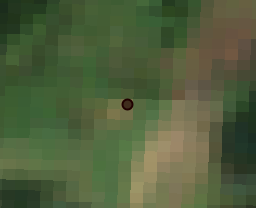

'Filename ./data/4_change_detection/images/9354_174.470843050161_-36.4085509819084_2022-11-30_2023-01-23.tif'

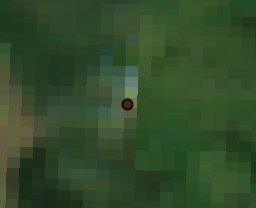

'Filename ./data/4_change_detection/images/9355_174.471187354444_-36.4081502271249_2022-11-30_2023-01-23.tif'

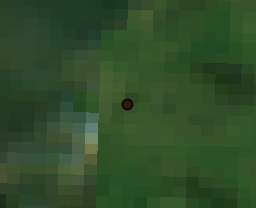

'Filename ./data/4_change_detection/images/9358_174.471214383214_-36.4074629331684_2022-11-30_2023-01-23.tif'

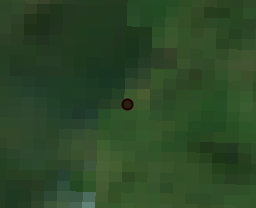

'Filename ./data/4_change_detection/images/9359_174.470596618927_-36.4062990209582_2022-11-30_2023-01-23.tif'

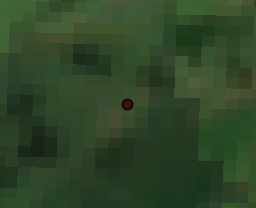

'Filename ./data/4_change_detection/images/9360_174.473653621302_-36.4078041074902_2022-11-30_2023-01-23.tif'

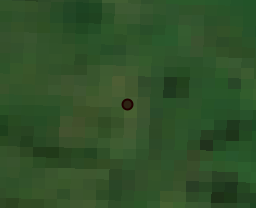

'Filename ./data/4_change_detection/images/9361_174.473667721703_-36.4076305298937_2022-11-30_2023-01-23.tif'

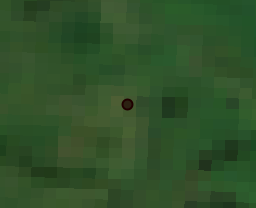

'Filename ./data/4_change_detection/images/9364_174.472670491405_-36.4089004367111_2022-11-30_2023-01-23.tif'

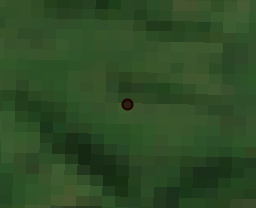

'Filename ./data/4_change_detection/images/9491_174.482928877184_-36.4059827795059_2022-11-30_2023-01-23.tif'

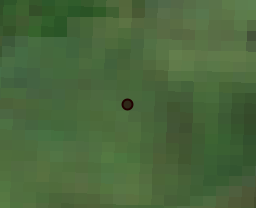

'Filename ./data/4_change_detection/images/9493_174.483681462676_-36.4060399692699_2022-11-30_2023-01-23.tif'

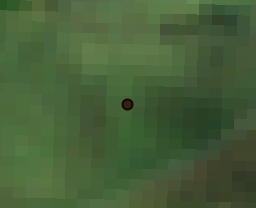

'Filename ./data/4_change_detection/images/9496_174.483219221746_-36.4060991497861_2022-11-30_2023-01-23.tif'

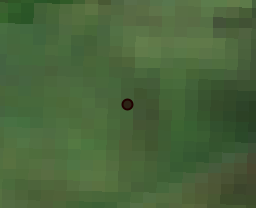

'Filename ./data/4_change_detection/images/9498_174.483377410107_-36.4064504799632_2022-11-30_2023-01-23.tif'

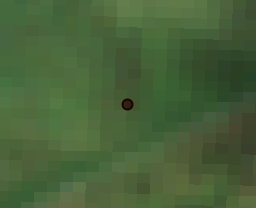

'Filename ./data/4_change_detection/images/9500_174.483310413128_-36.4066936372854_2022-11-30_2023-01-23.tif'

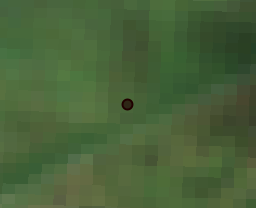

'Filename ./data/4_change_detection/images/9501_174.483156472888_-36.4067631731491_2022-11-30_2023-01-23.tif'

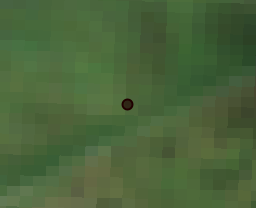

'Filename ./data/4_change_detection/images/9503_174.482337237998_-36.4064069092243_2022-11-30_2023-01-23.tif'

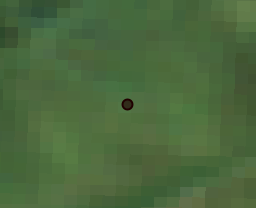

'Filename ./data/4_change_detection/images/9509_174.482625678849_-36.406922562696_2022-11-30_2023-01-23.tif'

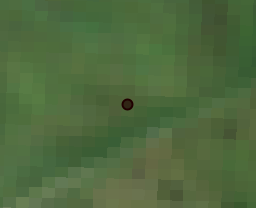

'Filename ./data/4_change_detection/images/9510_174.481433867586_-36.4071969201842_2022-11-30_2023-01-23.tif'

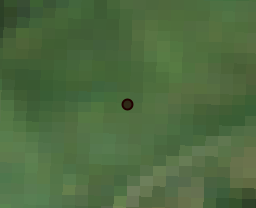

'Filename ./data/4_change_detection/images/9511_174.480927480185_-36.4068711374641_2022-11-30_2023-01-23.tif'

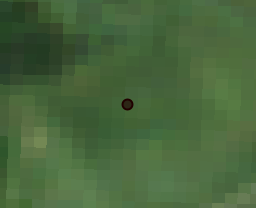

'Filename ./data/4_change_detection/images/9515_174.479470172098_-36.4076461836273_2022-11-30_2023-01-23.tif'

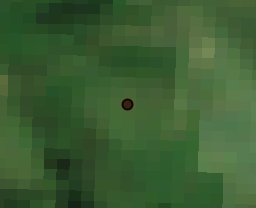

'Filename ./data/4_change_detection/images/9519_174.479109750491_-36.408324397703_2022-11-30_2023-01-23.tif'

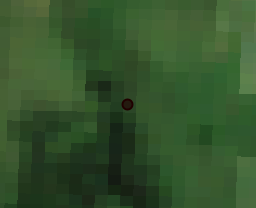

'Filename ./data/4_change_detection/images/9650_174.477335842416_-36.4088514215332_2022-11-30_2023-01-23.tif'

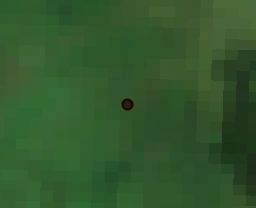

'Filename ./data/4_change_detection/images/9653_174.478565417373_-36.4081409054478_2022-11-30_2023-01-23.tif'

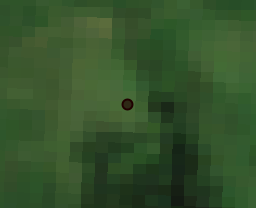

'Filename ./data/4_change_detection/images/9654_174.478448415845_-36.4081535529145_2022-11-30_2023-01-23.tif'

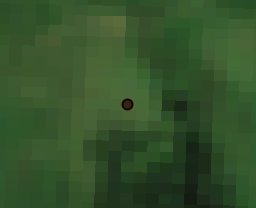

'Filename ./data/4_change_detection/images/9655_174.478313256117_-36.4081396359997_2022-11-30_2023-01-23.tif'

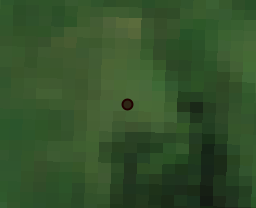

'Filename ./data/4_change_detection/images/9658_174.478231987015_-36.4076307299301_2022-11-30_2023-01-23.tif'

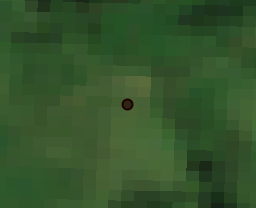

'Filename ./data/4_change_detection/images/11280_174.543881026625_-36.564693822369_2022-11-30_2023-01-23.tif'

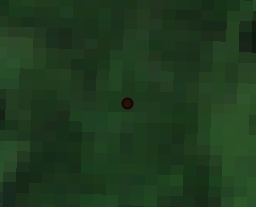

'Filename ./data/4_change_detection/images/11323_174.551195691389_-36.562980250311_2022-11-30_2023-01-23.tif'

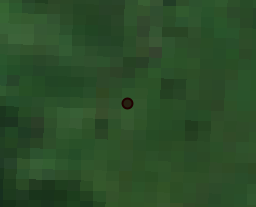

'Filename ./data/4_change_detection/images/11544_174.528176529747_-36.5638294879423_2022-11-30_2023-01-23.tif'

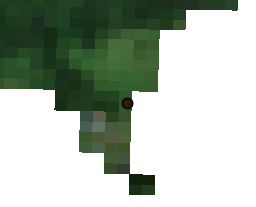

'Filename ./data/4_change_detection/images/11545_174.524861366025_-36.5652703977627_2022-11-30_2023-01-23.tif'

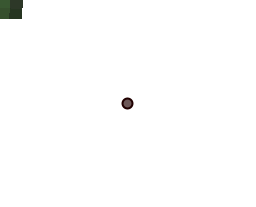

'Filename ./data/4_change_detection/images/11637_174.521782810722_-36.5659641834053_2022-11-30_2023-01-23.tif'

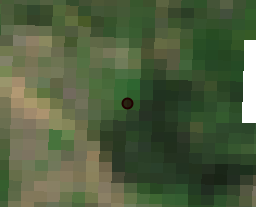

'Filename ./data/4_change_detection/images/11693_174.579299097023_-36.9511141857535_2022-11-30_2023-01-23.tif'

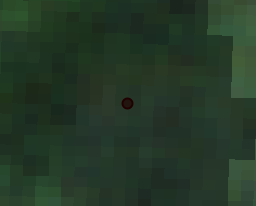

'Filename ./data/4_change_detection/images/11694_174.577327052332_-36.9531848460167_2022-11-30_2023-01-23.tif'

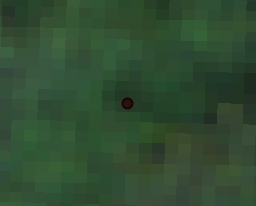

'Filename ./data/4_change_detection/images/11898_174.792299358367_-36.8531006145202_2022-11-27_2023-01-20.tif'

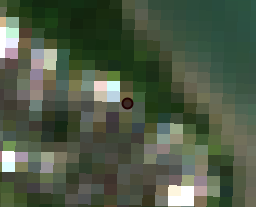

'Filename ./data/4_change_detection/images/11899_174.625725021567_-36.9417970494443_2022-11-28_2023-01-21.tif'

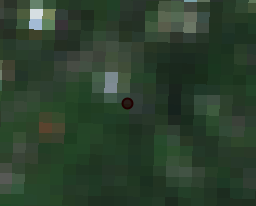

'Filename ./data/4_change_detection/images/11900_174.710566464673_-36.9256658197094_2022-11-27_2023-01-20.tif'

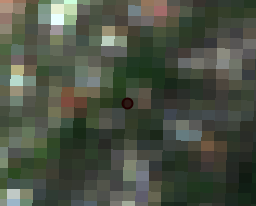

'Filename ./data/4_change_detection/images/11901_174.733455540282_-36.8037507496304_2022-11-27_2023-01-20.tif'

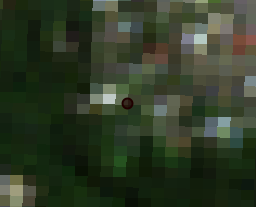

'Filename ./data/4_change_detection/images/11902_174.733379345631_-36.8038225069164_2022-11-27_2023-01-20.tif'

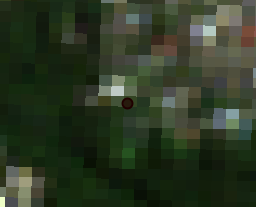

'Filename ./data/4_change_detection/images/11903_174.626178573531_-36.9354267150748_2022-11-27_2023-01-20.tif'

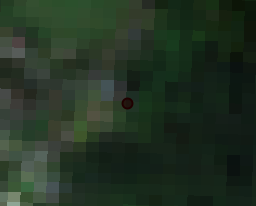

'Filename ./data/4_change_detection/images/11904_174.62364888468_-36.9430162550176_2024-11-27_2025-01-20.tif'

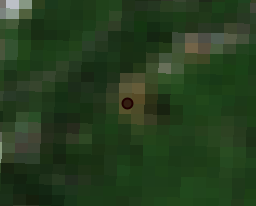

'Filename ./data/4_change_detection/images/11905_174.556928077112_-36.8686376994291_2022-11-27_2023-01-20.tif'

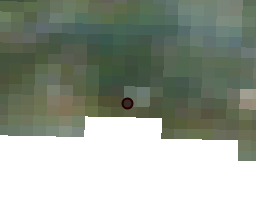

'Filename ./data/4_change_detection/images/11906_174.646471909892_-36.9447709450325_2022-11-27_2023-01-20.tif'

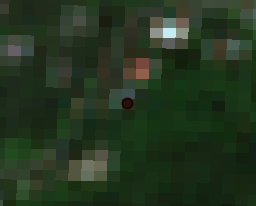

'Filename ./data/4_change_detection/images/11907_174.64655656753_-36.9445760003314_2022-11-27_2023-01-20.tif'

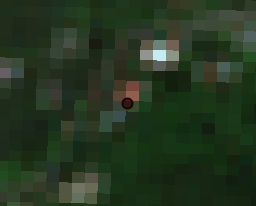

'Filename ./data/4_change_detection/images/11908_174.591768146988_-36.9347976148207_2022-11-30_2023-01-23.tif'

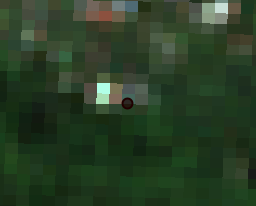

'Filename ./data/4_change_detection/images/11909_174.586210188655_-36.542706326647_2022-12-14_2023-02-06.tif'

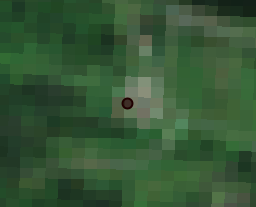

'Filename ./data/4_change_detection/images/11910_174.690927426242_-36.8075637182977_2022-11-27_2023-01-20.tif'

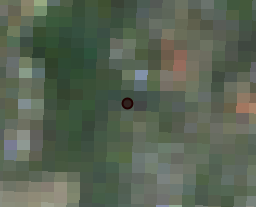

'Filename ./data/4_change_detection/images/11911_174.690856477682_-36.8074193964591_2022-11-27_2023-01-20.tif'

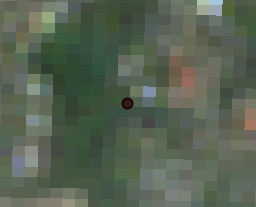

'Filename ./data/4_change_detection/images/11912_174.706529608883_-37.1338641012155_2022-11-27_2023-01-20.tif'

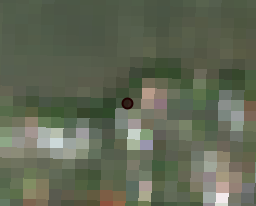

'Filename ./data/4_change_detection/images/11913_174.629223157042_-36.9381915876884_2022-11-27_2023-01-20.tif'

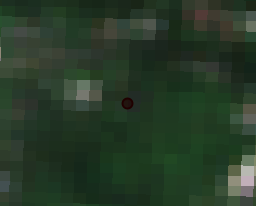

'Filename ./data/4_change_detection/images/11914_174.663083587046_-36.9446829933302_2022-11-28_2023-01-21.tif'

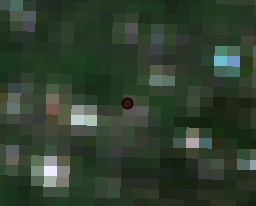

'Filename ./data/4_change_detection/images/11915_174.797044149013_-36.8658719228886_2022-11-27_2023-01-20.tif'

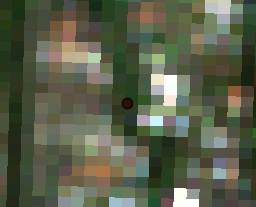

In [6]:
out_dir = './data/4_change_detection/'
start_date_offset = -60
end_date_offset = -6 # s2 revisit time is 5 days, make sure we have images before the event
buffer=50
cloud_filter=30
s2cloudless=S2Cloudless(ee)

for idx, event in gdf.iterrows():
    filename, filepath_with_marker = get_sentinel_image_thumbnail(
        ee,
        s2cloudless,
        event,
        idx,
        out_dir,
        start_date_offset=start_date_offset,
        end_date_offset=end_date_offset,
        buffer=buffer,
        cloud_filter=cloud_filter,
    )
    
    display(f"Filename {filename}")
    display(Image(filename=filepath_with_marker))